# **FACE DETETION AND FACE RECOGNITION**

**OBJECTIVES**

1. Download video data from YouTube, shorten the video and extract frames from the video.
2. Detect faces in an image using MTCNN a pretrained face detection model.
3. Perform face recognition of an image using Ineption-Resnet V1



In [40]:
!pip install facenet-pytorch
!pip install pytubefix

import torch
import cv2
import torchvision
import pytubefix
import sys
import shutil
import matplotlib.pyplot as plt

from pytubefix import YouTube
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image
from IPython.display import display, Video
from pathlib import Path
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


## **IMPORTING DATA**

**VIDEO DIRECTORY**

In [3]:
project_dir = Path("facedetection")
data_dir = "data"
video_dir = project_dir / data_dir

**DOWNLOAD VIDEO**

In [4]:
video_name = "shorts.mp4"
video_url = "https://www.youtube.com/shorts/zxGBtXk3lBI?feature=share"
yt = YouTube(video_url)

In [5]:
# Download highest resolution
stream = yt.streams.get_highest_resolution()
stream.download(filename='shorts.mp4')

'/content/shorts.mp4'

**VIDEO PATH**

In [6]:
input_video = video_dir / video_name
Video("shorts.mp4", width=400, embed=True)

## **EXPLORE DATA**

**VIDEO CAPTURE**

In [7]:
video_capture = cv2.VideoCapture("shorts.mp4")

if not video_capture.isOpened():
    print("Error: Video not opened.")
else:
    frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Frame rate: {frame_rate}")
    print(f"Total number of frames: {frame_count}")

Frame rate: 30.0
Total number of frames: 686


**FETCH FRAME**

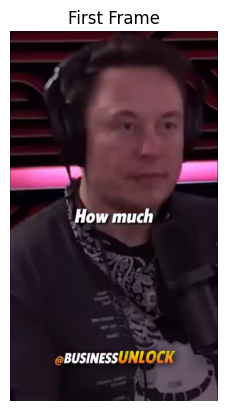

In [8]:
ret, first_frame = video_capture.read()

if ret:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read frame.")

**FRAMES DIRECTORY**

In [9]:
frames_dir = video_dir / "extracted_frames"
frames_dir.mkdir(parents=True, exist_ok=True)

**SAVE FRAMES**

In [10]:
interval = frame_rate * 0.2
frame_count = 0

print("Start extracting individual frames...")
while True:
    # read next frame from the video_capture
    ret, frame = video_capture.read()
    if not ret:
        print("Finished!")
        break  # Break the loop if there are no more frames

    # Save frames at every 'interval' frames
    if frame_count % 6 == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)

    frame_count += 1

video_capture.release()

Start extracting individual frames...
Finished!


**DISPLAY FRAMES**

In [11]:
def display_sample_images(dir_path, sample=5):
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_images = images[:sample]
        for sample_image in sample_images:
            image = read_image(str(sample_image))

            # Define resizing transformation that resizes to 240 x 240
            resize_transform = transforms.Resize((240, 240))
            # Resize image by using `resize_transform`
            image = resize_transform(image)
            image_list.append(image)
    grid = make_grid(image_list, nrow=5)
    image = to_pil_image(grid)
    return image


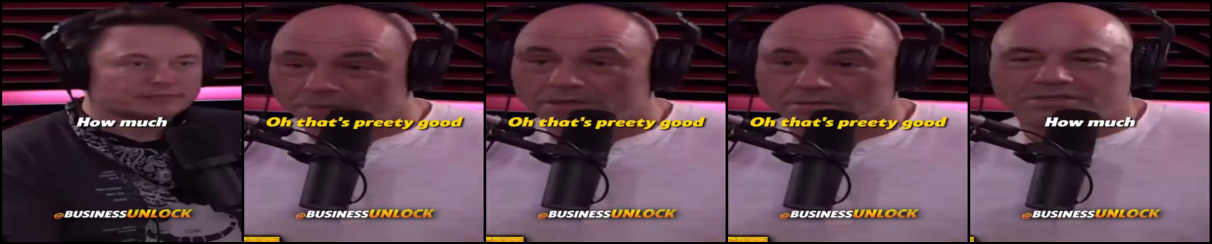

In [12]:
display_sample_images(frames_dir, 5)

## **FACE DETECTION**

We'll be using a pretrained Multi-Task Cascaded Convolutional Neural Network(MTCNN) to do face detection.

**INITIALIZE PRETRAINED MODEL**

In [13]:
mtcnn = MTCNN(device=device, keep_all=True, min_face_size=10, post_process=False)

In [14]:
sample_image_filename = "frame_102.jpg"
sample_image_path = frames_dir / sample_image_filename
sample_image = Image.open(sample_image_path)

In [15]:
boxes, probs = mtcnn.detect(sample_image)

In [16]:
print(boxes.shape)
print(boxes)

(1, 4)
[[23.35453987121582 41.85883331298828 230.811767578125 320.92626953125]]


**PLOT BOXES**

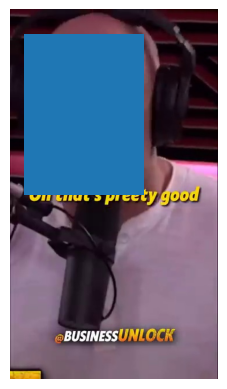

In [17]:
fig, ax = plt.subplots()
ax.imshow(sample_image);
for box in boxes:
  rectangle = plt.Rectangle(
      (box[0], box[1]), box[2] - box[0], box[3] - box[1]
  )
  ax.add_patch(rectangle)
plt.axis("off")
plt.show()

**FACIAL LANDMARKS**

In [18]:
boxes, probs, landmarks = mtcnn.detect(sample_image, landmarks=True)

In [19]:
print(landmarks)

[[[69.1839370727539 164.09902954101562]
  [168.49661254882812 172.6502685546875]
  [100.16336059570312 225.1275177001953]
  [69.42581176757812 274.7974853515625]
  [152.13206481933594 281.7878723144531]]]


**PLOT LANDMARKS**

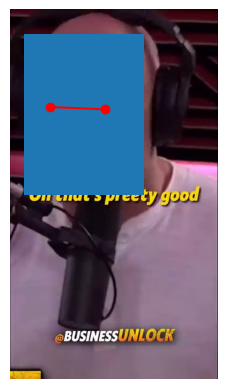

In [20]:
fig, ax = plt.subplots()
ax.imshow(sample_image);
for box in boxes:
  rectangle = plt.Rectangle(
      (box[0], box[1]), box[2] - box[0], box[3] - box[1]
  )
  ax.add_patch(rectangle)
  for point in landmarks:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");

****

**CROPPING DETECTED FACE**

In [21]:
faces = mtcnn(sample_image)
print(faces.shape)

torch.Size([1, 3, 160, 160])


torch.Size([3, 160, 160])


(-0.5, 159.5, 159.5, -0.5)

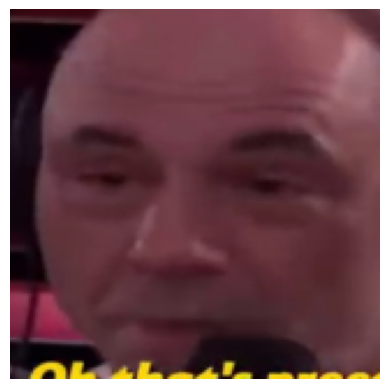

In [22]:
Grid = make_grid(faces, nrow=5)
print(Grid.shape)
plt.imshow(Grid.permute(1, 2, 0).int())
plt.axis("off")

## **FACE RECOGNITION**

To perform face recognition, we'll need a database of face embeeding of people we know the identity.
We'll create two sub directories of images of people we want to identify and generate the face embeeding and see which face embeeding is closest to the embeedings in our database.

**MAKE SUBDIRECTORY**

In [23]:
elon_mask_dir = frames_dir / "elon_mask"
elon_mask_dir.mkdir(parents=True, exist_ok=True)

In [24]:
joe_rogan_dir = frames_dir / "joe_rogan"
joe_rogan_dir.mkdir(parents=True, exist_ok=True)

**PREPARE A SUBSET OF IMAGES**

In [25]:
elon_mask_imgs = [
    "frame_138.jpg",
    "frame_144.jpg",
    "frame_150.jpg",
    "frame_156.jpg",
    "frame_162.jpg"

]

In [26]:
joe_rogan_imgs = [
    "frame_102.jpg",
    "frame_108.jpg",
    "frame_114.jpg",
    "frame_12.jpg",
    "frame_126.jpg"
]

In [27]:
elon_mask_img_path = [frames_dir / i for i in elon_mask_imgs]
print(f"Number of Images: {len(elon_mask_img_path)}")

Number of Images: 5


In [28]:
joe_rogan_img_path = [frames_dir / i for i in elon_mask_imgs]
print(f"Number of Images: {len(joe_rogan_img_path)}")

Number of Images: 5


**COPY IMAGES IN RESPECTIVE PATHS**

In [29]:
for img_path in elon_mask_img_path:
    shutil.copy(img_path, elon_mask_dir)

In [30]:
for img_path in joe_rogan_img_path:
    shutil.copy(img_path, joe_rogan_dir)

**INITIALIZE RESNET**

In [47]:
mtcnn0 = MTCNN(image_size=160, min_face_size=20, keep_all=False)
resnet = InceptionResnetV1(pretrained="vggface2").eval()

**IMAGE FOLDER**

In [34]:
dataset = datasets.ImageFolder(frames_dir)

In [37]:
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()}

**DATA LOADER**

In [38]:
def collate_fn(x):
  return x[0]

In [41]:
loader = DataLoader(dataset, collate_fn=collate_fn)

**DETECT FACE**

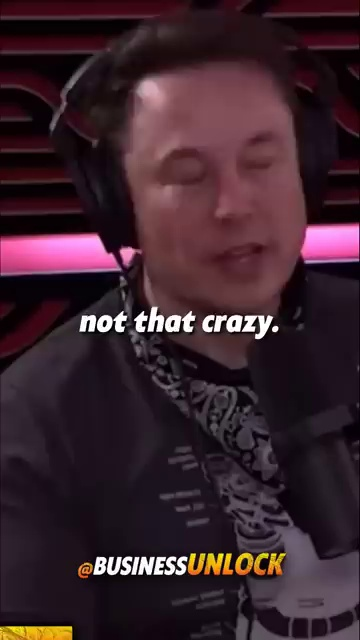

In [43]:
img, _ = iter(loader).__next__()
img

In [48]:
face, prob = mtcnn0(img, return_prob=True)

In [49]:
print(face.shape)

torch.Size([3, 160, 160])


**INCEPTION RESNET MODEL**

In [52]:
face_4d = face.unsqueeze(0)
embedding = resnet(face_4d)

**FILTER RESULTS**

In [54]:
name_to_embeddings = {name: [] for name in idx_to_class.values()}
for img, idx in loader:
  face, prob = mtcnn0(img, return_prob=True)
  if face is not None and prob > 0.90:
    face_4d = face.unsqueeze(0)
    emb = resnet(face_4d)
    name_to_embeddings[idx_to_class[idx]].append(emb)

**STACK EMBEDDINGS**

In [56]:
embeddings_elon = torch.stack(name_to_embeddings["elon_mask"])
embeddings_joe = torch.stack(name_to_embeddings["joe_rogan"])

**AVERAGE EMBEDDINGS**

In [57]:
avg_embedding_elon = torch.mean(embeddings_elon, dim=0)
avg_embedding_joe = torch.mean(embeddings_joe, dim=0)

**SAVE EMBEDDINGS**

In [58]:
embeddings_to_save = [
    (avg_embedding_elon, "elon_mask"),
    (avg_embedding_joe, "joe_rogan")
]
torch.save(embeddings_to_save, "embeddings.pt")

In [59]:
embedding_data = torch.load("embeddings.pt")
names = [name for _, name in  embedding_data]
print(names)

['elon_mask', 'joe_rogan']


In [72]:
test_img_path = Path("facedetection", "data", "extracted_frames", "frame_534.jpg")
test_image = Image.open(test_img_path)

In [67]:
img_cropped_list, prob_list = mtcnn(test_image, return_prob=True)
print(f"Number of detected faces: {len(prob_list)}")

Number of detected faces: 1


In [68]:
for i, prob in enumerate(prob_list):
  if prob > 0.90:
    face_4d = img_cropped_list[i].unsqueeze(0)
    emb = resnet(face_4d)

In [69]:
distances = {}
for known_embedding, name in embedding_data:
  distance = (emb - known_embedding).norm().item()
  distances[name] = distance
closest, min_distance = min(distances.items(), key=lambda x: x[1])
print(f"Closest: {closest}, Distance: {min_distance:.2f}")

Closest: elon_mask, Distance: 1.48


In [78]:
def recognize_faces(img_path, embedding_data, mtcnn, resnet, threshold=0.9):
    # Generating the bounding boxes, faces tensors, and probabilities
    image = Image.open(img_path)
    boxes, probs = mtcnn.detect(image)
    cropped_images = mtcnn(image)

    if boxes is None:
        return

    # This sets the image size and draws the original image
    width, height = image.size
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # Iterating over each face and comparing it against the pre-calculated embeddings
    # from our "database"
    for box, prob, face in zip(boxes, probs, cropped_images):
        if prob < 0.90:
            continue

        # Draw bounding boxes for all detected faces
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color="blue",
        )
        axis.add_patch(rect)

        # Find the closest face from our database of faces
        emb = resnet(face.unsqueeze(0))
        distances = {}
        for known_emb, name in embedding_data:
            dist = torch.dist(emb, known_emb).item()
            distances[name] = dist

        closest, min_dist = min(distances.items(), key=lambda x: x[1])

        # Drawing the box with recognition results
        name = closest if min_dist < threshold else "Unrecognized"
        color = "red" if name == "Unrecognized" else "blue"
        label = f"{name} {min_dist:.2f}"

        axis.text(box[0], box[1], label, fontsize=8, color=color)

    plt.axis("off")
    plt.show()

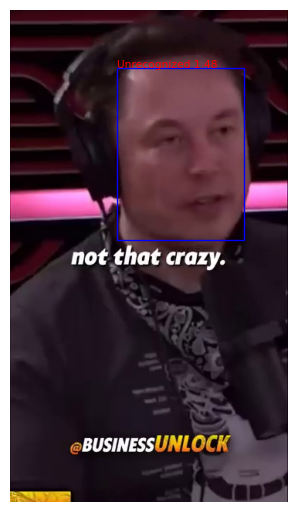

In [79]:
recognize_faces("/content/facedetection/data/extracted_frames/elon_mask/frame_150.jpg", embedding_data, mtcnn, resnet)